In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as col
import seaborn as sns
import ast

# Generic Functions

In [2]:
def get_training_hyper(row, hyper="seed"):
    hypers = ast.literal_eval(row["config/training"])
    return hypers[hyper]

def get_problem_hyper(row, hyper="lam"):
    hypers = ast.literal_eval(row["config/problem"])
    return hypers[hyper]

def get_d_hypers(row, hyper="n_hidden_units"):
    hypers = ast.literal_eval(row["config/discriminator"])
    return hypers[hyper] 

def get_g_hypers(row, hyper="n_hidden_units"):
    hypers = ast.literal_eval(row["config/generator"])
    return hypers[hyper] 

def get_expanded_df(results_df, optim="sgd", lam=False):
    
    # List the training hyperparameters
    if optim == "sgd":
        training_hypers = ["seed", "d_lr", "g_lr", "gamma", "momentum", "step_size"]
        precise_cols = training_hypers[1:5]
    elif optim == "adam":
        training_hypers = ["seed", "d_lr", "g_lr", "gamma", "g_betas", "d_betas", "step_size"]          
        precise_cols = training_hypers[1:4]
    else:
        raise Exception(f"optimizer {optim} not recognized")

    # List the discriminator and generator network hyperparameters
    nn_hypers = ["n_hidden_units", "n_hidden_layers"]

    # Add a new column for each training hyperparameter
    for hyper in training_hypers:
        results_df[hyper] = results_df.apply(lambda row: get_training_hyper(row, hyper), axis=1)

    # Add a new column for each discriminator and generator hyperparameter
    for hyper in nn_hypers:
        results_df["d_"+hyper] = results_df.apply(lambda row: get_d_hypers(row, hyper), axis=1)
        results_df["g_"+hyper] = results_df.apply(lambda row: get_g_hypers(row, hyper), axis=1)
        
    # Add a column for lambda
    if lam:
        precise_cols.append("lam")
        results_df["lam"] = results_df.apply(lambda row: get_problem_hyper(row, "lam"), axis=1)
        
    # Increase precision of several hypers
    for col in precise_cols:
        results_df[col] = results_df[col].map(lambda x: '{0:.17}'.format(x))
        
    # Drop unnecessary columns
    results_df = results_df.drop(["time_this_iter_s", "done", "timesteps_total", "episodes_total", 
                                  "training_iteration", "experiment_id", "timestamp", "time_total_s", 
                                  "pid", "node_ip", "time_since_restore", "timesteps_since_restore", 
                                  "iterations_since_restore", "trial_id", "config/generator", 
                                  "config/discriminator", "config/problem", "config/training"], axis=1)   
    return results_df

In [3]:
def plot_results(results_df, x, y, max_mse=1):
    fig, ax = plt.subplots(figsize=(10,8))
    results_df = results_df[results_df["mean_squared_error"]<max_mse].copy()
    x_vals = [float(x_i) for x_i in results_df[x]]
    y_vals = [float(y_i) for y_i in results_df[y]]
    sp = ax.scatter(x_vals, y_vals, c=results_df["mean_squared_error"], norm=col.LogNorm())
    cb = fig.colorbar(sp, ax=ax)
    cb.set_label("Mean squared error", rotation=270)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.show()
    
def plot_bivariate(results_df, max_mse=1):
    fig, axs = plt.subplots(2, 4, figsize=(14,8))
    results_df = results_df[results_df["mean_squared_error"]<max_mse].copy()
    axs = axs.ravel()
    features = ["d_lr", "g_lr", "gamma", "step_size", "g_betas", "d_betas"]
    for i, feature in enumerate(features):
        y_vals = [float(y_i) for y_i in results_df["mean_squared_error"]]
        if feature == "g_betas":
            lists = results_df[feature].to_numpy()
            try:
                lists = [np.fromstring(l[1:-1], sep=' ') for l in lists]
            except:
                pass
            for j in range(2):
                x_vals = [float(l[j]) for l in lists]
                axs[i+j].scatter(x_vals, y_vals)
                axs[i+j].set_xlabel(f"{feature}_{j}")
                axs[i+j].set_yscale("log")
        elif feature == "d_betas":
            lists = results_df[feature].to_numpy()
            try:
                lists = [np.fromstring(l[1:-1], sep=' ') for l in lists]
            except:
                pass
            for j in range(2):
                x_vals = [float(l[j]) for l in lists]
                axs[i+j+1].scatter(x_vals, y_vals)
                axs[i+j+1].set_xlabel(f"{feature}_{j}")
                axs[i+j+1].set_yscale("log")
        else:
            x_vals = [float(x_i) for x_i in results_df[feature]]
            axs[i].scatter(x_vals, y_vals)
            axs[i].set_xlabel(feature)
            axs[i].set_yscale("log")
    plt.tight_layout()

# 1. EXP

In [4]:
# Read in the EXP results
exp_results = pd.read_csv("gan_results/ray_tune_exp.csv", usecols=np.arange(1,22))
exp_results = get_expanded_df(exp_results, optim="adam")
exp_results.loc[exp_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
344,3.182350e-16,2021-10-04_00-34-42,holy7c24203.rc.fas.harvard.edu,0,0.003463728449223625,0.064090137485700235,0.94530362439311566,[0.53031704 0.3746971 ],[0.11049184 0.61258848],2,40,30,5,5
249,3.182350e-16,2021-10-04_00-34-12,holy7c24203.rc.fas.harvard.edu,1,0.0152970175031675,0.078605929822058052,0.96357947980181735,[0.42361053 0.52804964],[0.26906948 0.88788478],3,20,40,3,3
1007,3.182350e-16,2021-10-04_00-39-09,holy7c24203.rc.fas.harvard.edu,2,0.097506579814443814,0.077674898674501128,0.93757903992043412,[0.65269048 0.66281278],[0.40414071 0.57584149],3,20,50,4,4
116,3.182350e-16,2021-10-04_00-33-32,holy7c24203.rc.fas.harvard.edu,3,0.035732925640479127,0.060308911115170581,0.90467347451035574,[0.23153678 0.83059213],[0.06683732 0.26089678],8,50,50,4,4
18,3.182350e-16,2021-10-04_00-32-46,holy7c24203.rc.fas.harvard.edu,4,0.0098003953476289898,0.033256070589426749,0.94248317439104889,[0.42579896 0.89779523],[0.28879025 0.71445169],6,30,50,2,5
175,3.182350e-16,2021-10-04_00-33-53,holy7c24203.rc.fas.harvard.edu,5,0.0067945292193244775,0.055691327344828172,0.93719261819044797,[0.16960435 0.61929928],[0.03860631 0.84166817],7,30,40,5,2
118,3.182350e-16,2021-10-04_00-33-34,holy7c24203.rc.fas.harvard.edu,6,0.0096129385952840388,0.07741629065313653,0.91454140826703012,[0.73041718 0.18698354],[0.92884044 0.59578656],9,30,40,3,5
28,3.182350e-16,2021-10-04_00-32-42,holy7c24203.rc.fas.harvard.edu,7,0.0071123949776022597,0.094548446005977366,0.93211242821420071,[0.18245262 0.22982304],[0.07957338 0.54931604],6,50,30,2,4
60,3.182350e-16,2021-10-04_00-33-02,holy7c24203.rc.fas.harvard.edu,8,0.0075996472493229279,0.060733680055341507,0.9618182793473492,[0.18816457 0.40685192],[0.5633916 0.16836895],4,40,50,2,3
24,3.182350e-16,2021-10-04_00-32-48,holy7c24203.rc.fas.harvard.edu,9,0.088331316132474386,0.05857065401447941,0.96775940941054295,[0.64147684 0.7256815 ],[0.4321078 0.62824842],2,20,50,5,5


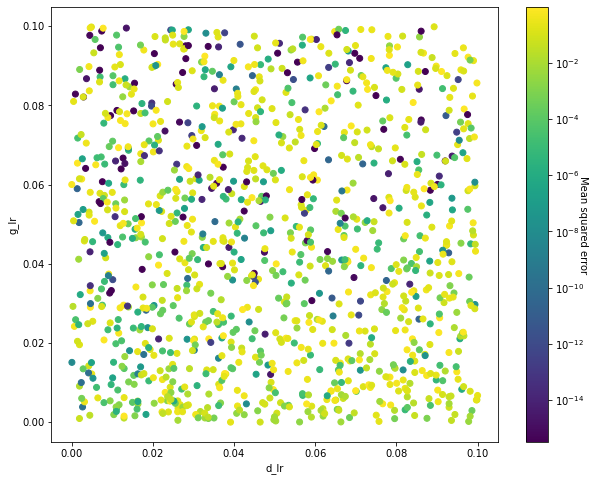

In [5]:
plot_results(exp_results, "d_lr", "g_lr")

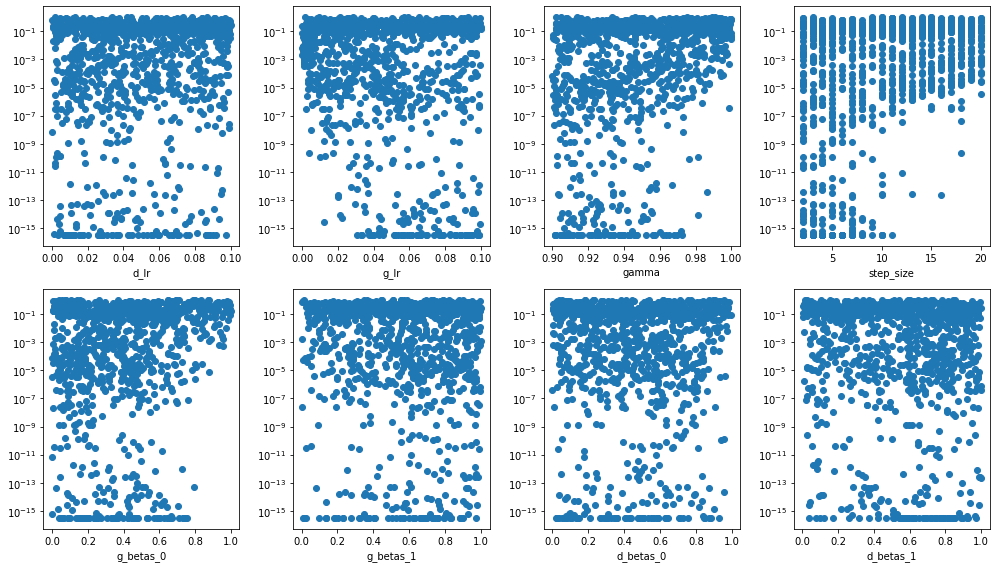

In [6]:
plot_bivariate(exp_results)

# 2. SHO

In [7]:
# Read in the first SHO results
sho_results = pd.read_csv("gan_results/ray_tune_sho.csv", usecols=np.arange(1,22))
sho_results = get_expanded_df(sho_results, optim="adam")
sho_results.loc[sho_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1211,2.700784e-12,2021-10-03_10-50-11,holy7c24202.rc.fas.harvard.edu,0,0.00048861147485534354,0.0059646176842056914,0.97862221657386639,[0.36317042 0.75224866],[0.58413382 0.45382877],19,50,40,3,3


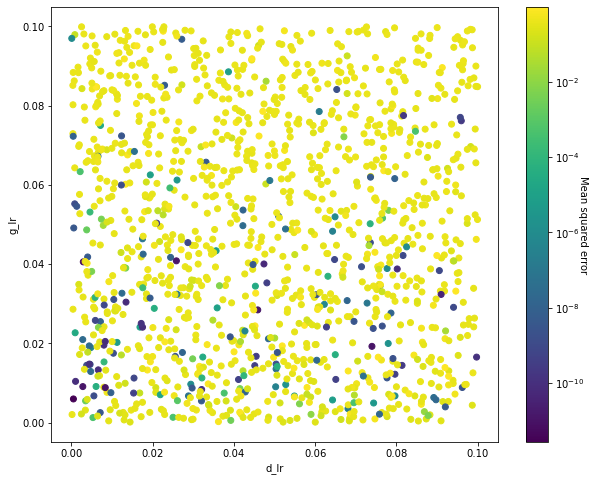

In [8]:
plot_results(sho_results, "d_lr", "g_lr")

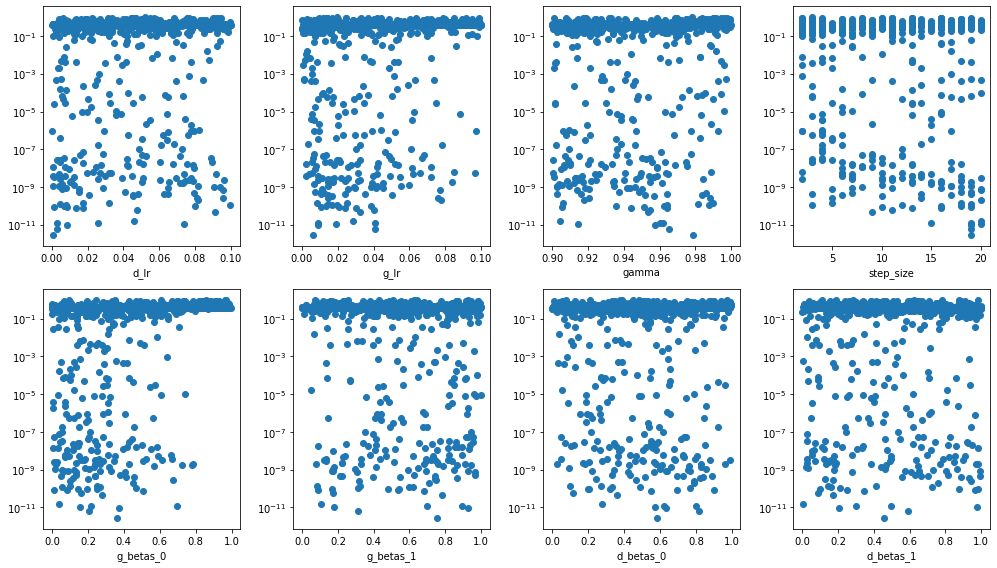

In [9]:
plot_bivariate(sho_results)

# 3. NLO

In [10]:
# Read in the first NLO results
nlo_results = pd.read_csv("gan_results/ray_tune_nlo.csv", usecols=np.arange(1,22))
nlo_results = get_expanded_df(nlo_results, optim="adam")
nlo_results.loc[nlo_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1807,7.681183e-13,2021-10-03_12-05-24,holy7c24203.rc.fas.harvard.edu,0,0.02104329548894603,0.010648723263851936,0.98037812391306267,[0.22544921 0.33148318],[0.36273349 0.55130697],15,20,40,2,4


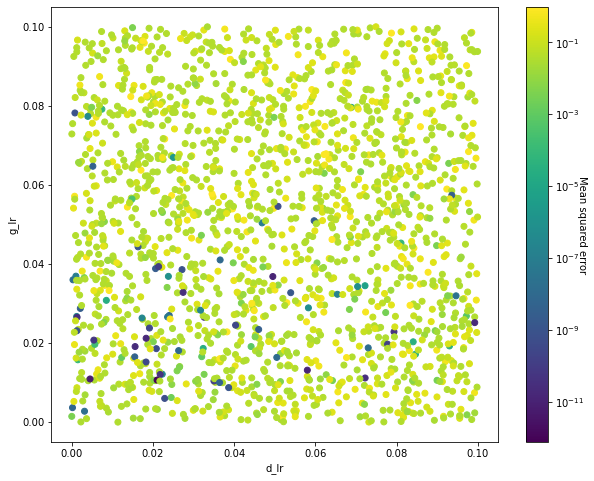

In [11]:
plot_results(nlo_results, "d_lr", "g_lr")

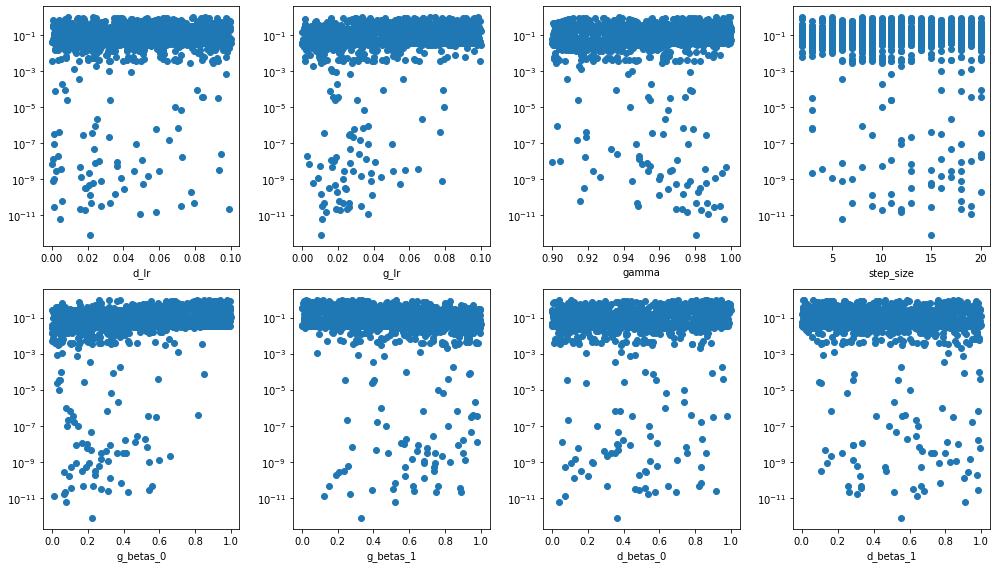

In [12]:
plot_bivariate(nlo_results)

# 4. POS

In [13]:
# Read in the first POS results
pos_results = pd.read_csv("gan_results/ray_tune_pos.csv", usecols=np.arange(1,22))
pos_results = get_expanded_df(pos_results, optim="adam")
pos_results.loc[pos_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
938,6.398321e-13,2021-10-03_11-33-14,holy7c24201.rc.fas.harvard.edu,0,0.02154824129565415,0.019086634787137204,0.95727502453840718,[0.13931808 0.36966975],[0.74574617 0.7590883 ],9,30,50,2,4


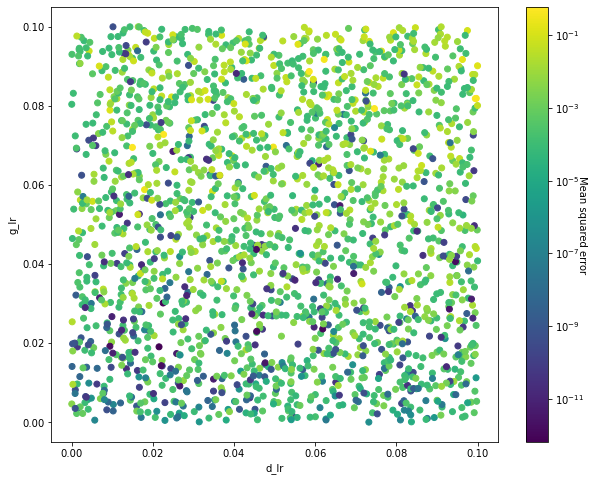

In [14]:
plot_results(pos_results, "d_lr", "g_lr")

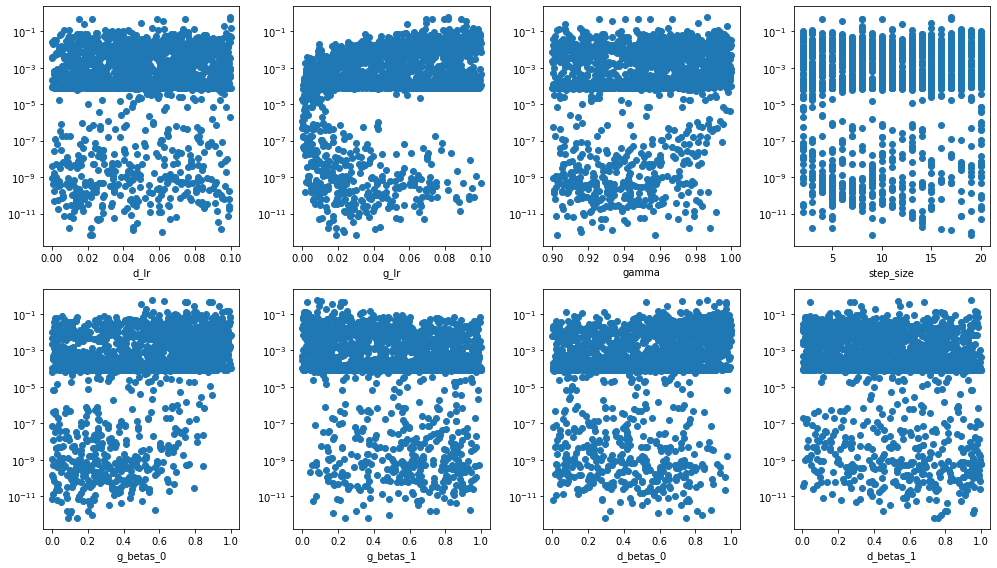

In [15]:
plot_bivariate(pos_results)

# 5. SIR

In [16]:
# Read in the SIR results
sir_results = pd.read_csv("gan_results/ray_tune_sir.csv", usecols=np.arange(1,22))
sir_results = get_expanded_df(sir_results, optim="adam")
sir_results.loc[sir_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
596,6.156667e-05,2021-10-12_18-33-38,holy7c24301.rc.fas.harvard.edu,0,0.017579260186589628,0.034451952039986626,0.92149233741088388,[0.11111877 0.34393505],[0.27511734 0.01780552],15,20,30,3,5
936,7.460055e-07,2021-10-12_19-06-29,holy7c24301.rc.fas.harvard.edu,1,0.026709950169583295,0.054584484598163167,0.98796095174984133,[0.34511251 0.49410708],[0.57369865 0.12496358],15,50,20,2,3
601,2.282120e-08,2021-10-12_18-35-45,holy7c24301.rc.fas.harvard.edu,2,0.055852573882656187,0.036727431813311041,0.97183350403592317,[0.05575282 0.24209578],[0.06706658 0.96131978],15,40,20,5,2
1050,1.711286e-09,2021-10-12_19-23-27,holy7c24301.rc.fas.harvard.edu,3,0.0048938616305375755,0.011746072513997606,0.99422115701902469,[0.23990367 0.24735706],[0.21180557 0.12231498],15,30,50,3,3
161,3.918958e-07,2021-10-12_17-54-40,holy7c24301.rc.fas.harvard.edu,4,0.026706883947478804,0.051583725281754533,0.91410675093364857,[0.38013809 0.73582533],[0.22341412 0.0205174 ],15,50,40,4,2
1740,8.256135e-05,2021-10-12_20-09-04,holy7c24301.rc.fas.harvard.edu,5,0.029657900788926328,0.018674665658307402,0.96764334446457845,[0.15587178 0.80166496],[0.27684222 0.32423394],15,30,50,3,2
1997,9.729931e-09,2021-10-12_20-32-09,holy7c24301.rc.fas.harvard.edu,6,0.001324048869577965,0.016508029720849599,0.99156553688229698,[0.20577781 0.39938013],[0.53829427 0.68265652],15,50,20,2,2
1054,1.093240e-04,2021-10-12_19-12-30,holy7c24301.rc.fas.harvard.edu,7,0.052822998736473295,0.077786109578677043,0.97477977740821875,[0.32196359 0.85219985],[0.23828286 0.94825907],15,20,20,2,2
207,3.397119e-08,2021-10-12_18-04-59,holy7c24301.rc.fas.harvard.edu,8,0.048650473872476951,0.014543941769487173,0.9832661450279524,[0.04352082 0.95235106],[0.17485836 0.52809463],15,50,30,4,2
346,9.912646e-07,2021-10-12_18-27-18,holy7c24301.rc.fas.harvard.edu,9,0.057628618134113678,0.0085065146757328965,0.99302233246445448,[0.06028212 0.59794421],[0.35710909 0.56631151],15,40,40,5,2


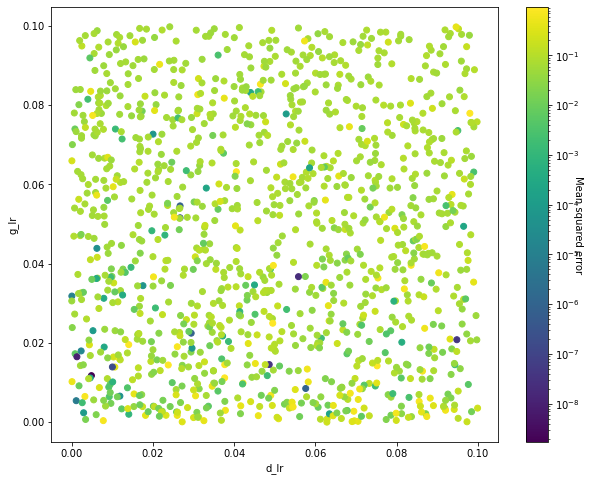

In [17]:
plot_results(sir_results, "d_lr", "g_lr")

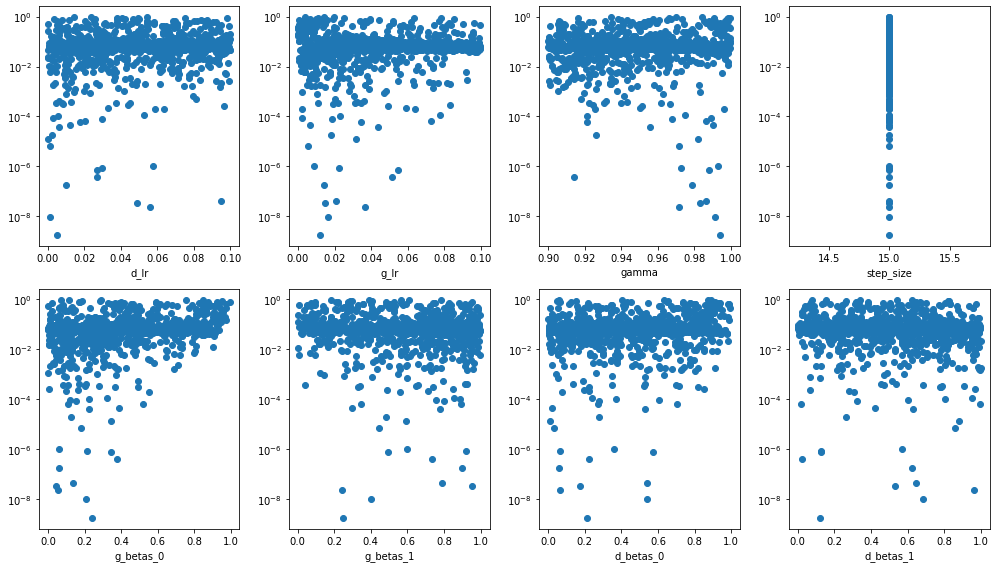

In [18]:
plot_bivariate(sir_results)

# 6. RANS

In [19]:
# Read in the RANS results
rans_results = pd.read_csv("gan_results/ray_tune_rans.csv", usecols=np.arange(1,22))
rans_results = get_expanded_df(rans_results, optim="adam")
rans_results.loc[rans_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
12,159.826357,2021-10-04_12-29-33,holy7c24401.rc.fas.harvard.edu,0,0.047102637906597022,0.087290889611672293,0.95755480141023575,[0.35706326 0.45743051],[0.05630037 0.96237312],2,20,40,4,2
49,162.921950,2021-10-04_12-40-28,holy7c24401.rc.fas.harvard.edu,1,0.013037888418553361,0.068179929128487693,0.91722048060475747,[0.87877983 0.74602319],[0.06234685 0.63103163],9,50,20,3,3
51,161.607413,2021-10-04_12-40-14,holy7c24401.rc.fas.harvard.edu,2,0.077748558432677459,0.076515395502946462,0.92417279919135242,[0.63717351 0.35698444],[0.29409961 0.23383043],13,40,50,3,3
13,156.151671,2021-10-04_12-30-14,holy7c24401.rc.fas.harvard.edu,3,0.058961726163355238,0.028452255507075089,0.95779376188963516,[0.7654043 0.64097131],[0.83354928 0.65191265],12,40,50,5,2
144,158.580074,2021-10-04_13-37-28,holy7c24401.rc.fas.harvard.edu,4,0.054393571770575959,0.053718724748984169,0.94497176541005778,[0.38566445 0.95113745],[0.36412546 0.21496849],3,40,20,3,3
68,124.108505,2021-10-04_12-42-06,holy7c24401.rc.fas.harvard.edu,5,0.038028006378184487,0.047213898930652975,0.92032519391415613,[0.38403368 0.43670135],[0.96234936 0.1028605 ],20,30,50,5,3
114,138.253638,2021-10-04_13-07-50,holy7c24401.rc.fas.harvard.edu,6,0.048057269120813588,0.026402378704027226,0.95766592664024797,[0.15207008 0.87110651],[0.88432302 0.14975234],9,40,30,3,5
66,160.587602,2021-10-04_12-42-44,holy7c24401.rc.fas.harvard.edu,7,0.094486036958194075,0.086274070812989545,0.93404764420015407,[0.37594888 0.52460457],[0.88219594 0.80796156],15,40,30,3,4
176,161.915595,2021-10-04_13-40-39,holy7c24401.rc.fas.harvard.edu,8,0.033656041083068376,0.085933815423378759,0.91017047089719494,[0.03062641 0.76398511],[0.22846284 0.72158713],6,50,30,3,2
151,153.241244,2021-10-04_13-29-11,holy7c24401.rc.fas.harvard.edu,9,0.070431661176774449,0.079383774321807182,0.98121480812943707,[0.06006626 0.90937366],[0.36657204 0.77572945],13,30,40,4,2


# 7. COO

In [20]:
# Read in the COO results
coo_results = pd.read_csv("gan_results/ray_tune_coo.csv", usecols=np.arange(1,22))
coo_results = get_expanded_df(coo_results, optim="adam")
coo_results.loc[coo_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
557,2.483194e-01,2021-10-16_12-37-13,holy7c24201.rc.fas.harvard.edu,0,0.039246600978446816,0.011829865004749592,0.91985048532973279,[0.61536114 0.45984507],[0.84191029 0.41882645],19,30,20,2,4
948,4.524419e-08,2021-10-16_13-37-53,holy7c24201.rc.fas.harvard.edu,1,0.082286188095080953,0.0042151418408642683,0.99756482157907311,[0.60325852 0.61447363],[0.41218949 0.11003992],16,40,40,2,5
203,1.923728e-01,2021-10-16_12-04-46,holy7c24201.rc.fas.harvard.edu,2,0.055689674116320358,0.046694283003550337,0.97095767741962735,[0.07391431 0.36827023],[0.08150694 0.61480754],13,40,20,2,3
564,2.395774e-01,2021-10-16_12-39-24,holy7c24201.rc.fas.harvard.edu,3,0.0039382350314899183,0.0076367845603473785,0.95923909958589448,[0.29683833 0.1316118 ],[0.93607832 0.75782043],11,30,30,5,3
1286,2.619943e-01,2021-10-16_13-51-08,holy7c24201.rc.fas.harvard.edu,4,0.052170899616416987,0.0061562943607780347,0.97622257664417089,[0.00561211 0.56634871],[0.80638658 0.74141113],7,50,30,3,4
970,2.305903e-01,2021-10-16_13-18-08,holy7c24201.rc.fas.harvard.edu,5,0.074937220353053696,0.0086941463637413129,0.98753003395920202,[0.50736104 0.60153803],[0.62280355 0.90342149],4,40,20,2,4
1468,2.356418e-01,2021-10-16_14-09-19,holy7c24201.rc.fas.harvard.edu,6,0.0014694256008514549,0.046985011672084867,0.93154291853503579,[0.42620914 0.29497788],[0.50074863 0.86940254],20,20,20,2,2
438,2.413512e-01,2021-10-16_12-25-26,holy7c24201.rc.fas.harvard.edu,7,0.036436082778760856,0.015937652799133829,0.95959567203648877,[0.45100989 0.50820223],[0.86121807 0.8849093 ],9,30,20,3,2
1084,2.346029e-01,2021-10-16_13-29-07,holy7c24201.rc.fas.harvard.edu,8,0.090870321541714497,0.0051103693637390242,0.96614183164276835,[0.56776699 0.55204843],[0.66552172 0.4534717 ],17,30,50,3,2
66,1.710943e-01,2021-10-16_11-48-48,holy7c24201.rc.fas.harvard.edu,9,0.0028788231906645982,0.016131652662052378,0.98623229166201964,[0.1046891 0.62406552],[0.86789091 0.63042278],5,40,50,3,2


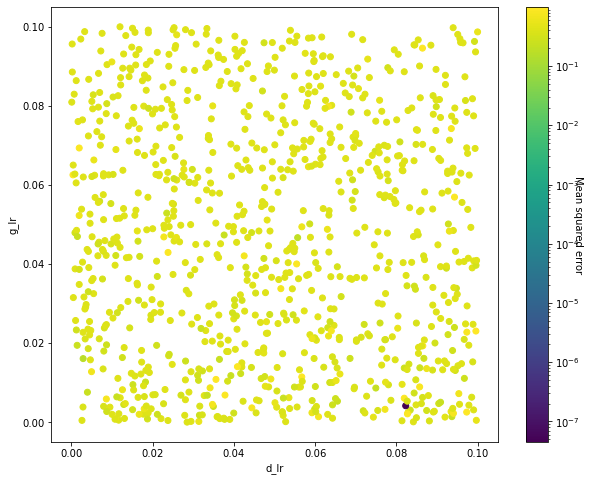

In [21]:
plot_results(coo_results, "d_lr", "g_lr")

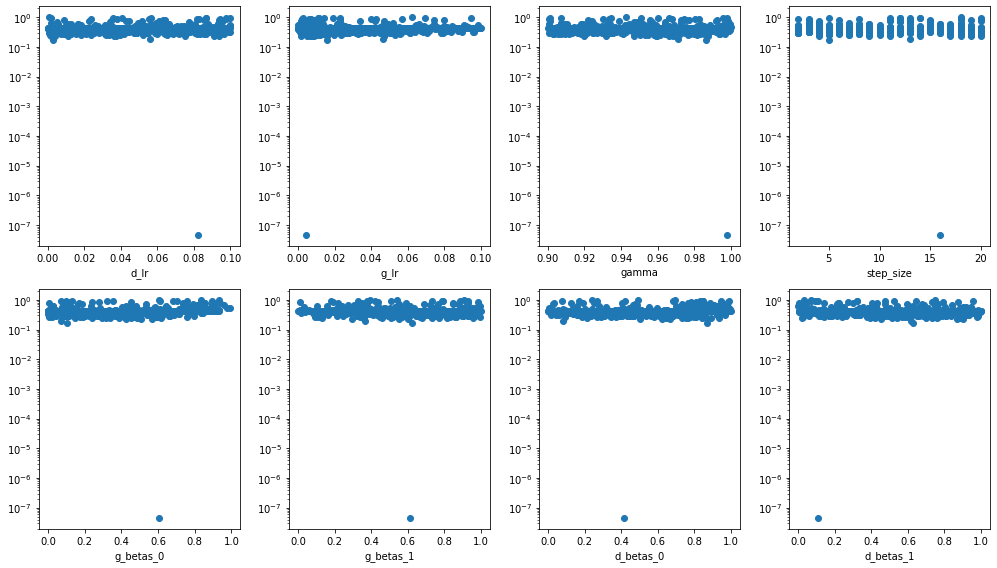

In [22]:
plot_bivariate(coo_results)

# 8. WAV

In [23]:
# Read in the WAV results
wav_results = pd.read_csv("gan_results/ray_tune_wav.csv", usecols=np.arange(1,22))
wav_results = get_expanded_df(wav_results, optim="adam")
wav_results.loc[wav_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1370,1.104161e-08,2021-10-23_21-36-47,holy7c18312.rc.fas.harvard.edu,0,0.052332314332198981,0.038445110278490964,0.96834856027601979,[0.51460513 0.78576023],[0.51778489 0.20388569],15,50,20,2,3
1748,2.713383e-08,2021-10-23_21-51-48,holy7c18312.rc.fas.harvard.edu,1,0.071004835544342004,0.012915989603012242,0.97354697490660536,[0.04045274 0.66993844],[0.73344429 0.10333145],15,30,40,2,3
1655,2.853997e-08,2021-10-23_21-50-16,holy7c18312.rc.fas.harvard.edu,2,0.020471970258897777,0.0075283170205287155,0.98946019292035547,[0.62524482 0.78950836],[0.41636603 0.04255884],16,20,20,5,5
641,1.285749e-08,2021-10-23_21-11-46,holy7c18312.rc.fas.harvard.edu,3,0.083519512402080595,0.014703163749818228,0.97233687328824514,[0.63088288 0.61488355],[0.27542907 0.47664216],17,30,30,2,2
462,1.732102e-08,2021-10-23_21-05-12,holy7c18312.rc.fas.harvard.edu,4,0.02407061390045033,0.015243223366449916,0.95536263412416522,[0.30113667 0.79930577],[0.1579113 0.1755364],17,40,50,2,2
1026,7.832441e-08,2021-10-23_21-24-27,holy7c18312.rc.fas.harvard.edu,5,0.090707819801933695,0.0099918847978794478,0.94842631440092706,[0.0101174 0.67631232],[0.53867025 0.96607522],19,50,50,2,2
53,6.516200e-09,2021-10-23_20-51-40,holy7c18312.rc.fas.harvard.edu,6,0.0001176382403693117,0.019087237793961168,0.96569463805888156,[0.67499221 0.790766 ],[0.09926623 0.17844521],19,30,20,2,4
522,3.114213e-07,2021-10-23_21-06-05,holy7c18312.rc.fas.harvard.edu,7,0.075353948064949675,0.025229536447072813,0.95689210726969987,[0.16846918 0.70422515],[0.84743454 0.79461788],15,20,20,2,2
1378,1.778459e-07,2021-10-23_21-35-49,holy7c18312.rc.fas.harvard.edu,8,0.05452256910626524,0.019642670029566576,0.93532321267329688,[0.65843324 0.64003827],[0.51379814 0.17329707],17,50,30,4,2
1196,6.722187e-09,2021-10-23_21-32-55,holy7c18312.rc.fas.harvard.edu,9,0.088441066074259264,0.012124383626117501,0.95336880203327612,[0.29551987 0.35822444],[0.5751795 0.13306347],18,50,50,2,4


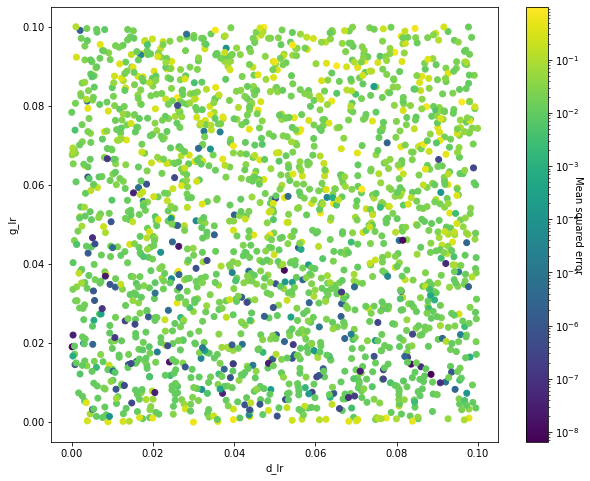

In [24]:
plot_results(wav_results, "d_lr", "g_lr")

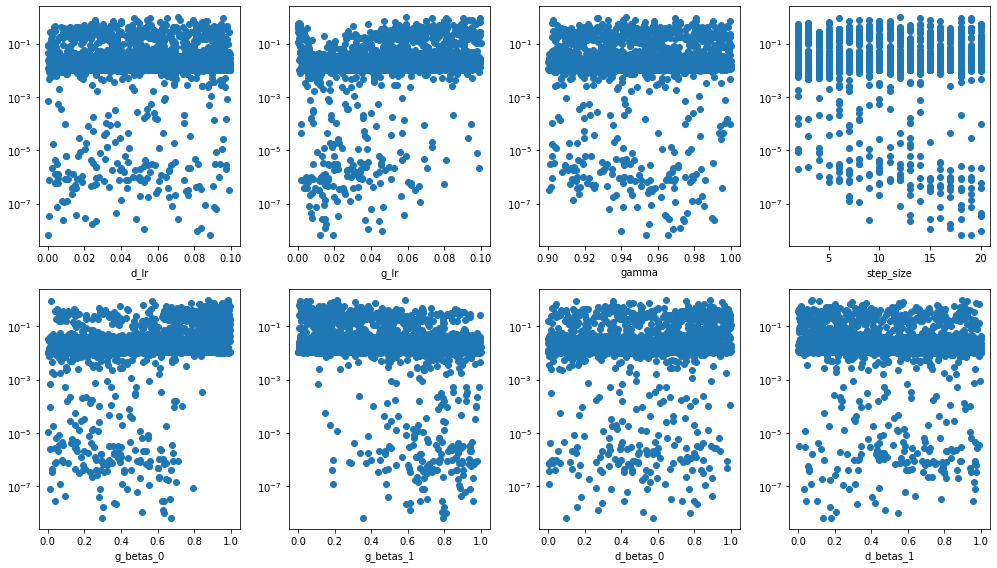

In [25]:
plot_bivariate(wav_results)

# 9. BUR

After the first round of hyperparameter tuning, I obtained no good results and noticed that BUR seems to prefer smaller learning rates. After changing the learning rate bound and rerunning, I got great results! This indicates the importance (and sensitivity) of the hyperparameter search space. I should try this on other experiments like SIR and COO.

In [26]:
# Read in the BUR results
bur_results = pd.read_csv("gan_results/ray_tune_bur.csv", usecols=np.arange(1,22))
bur_results = get_expanded_df(bur_results, optim="adam")
bur_results.loc[bur_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
324,5.385410e-08,2021-10-31_21-03-38,holy7c24101.rc.fas.harvard.edu,0,0.012282615331308139,0.011440048157738242,0.93610392311907453,[0.30218034 0.30760473],[0.47405901 0.68369699],16,40,30,4,2
1253,2.412334e-07,2021-10-31_22-06-30,holy7c24101.rc.fas.harvard.edu,1,0.0041122180809027489,0.010887437546214119,0.98737017257635018,[0.02094906 0.07560133],[0.18543664 0.5298049 ],2,20,30,5,2
1576,6.179391e-08,2021-10-31_22-32-43,holy7c24101.rc.fas.harvard.edu,2,0.0041396589952699655,0.011433352976194156,0.97578463620388511,[0.17524756 0.68043969],[0.28010914 0.92929655],12,30,20,4,4
687,1.966154e-07,2021-10-31_21-26-54,holy7c24101.rc.fas.harvard.edu,3,0.013137722358748749,0.01265323303613039,0.9421595423676884,[0.65627937 0.86189406],[0.73664029 0.48100027],7,40,20,3,3
1366,1.694258e-07,2021-10-31_22-17-27,holy7c24101.rc.fas.harvard.edu,4,0.0084352997713489052,0.0089510993143552871,0.98597249113184593,[0.49177472 0.52979116],[0.51064432 0.14613542],7,20,40,5,3
1307,5.342924e-08,2021-10-31_22-13-44,holy7c24101.rc.fas.harvard.edu,5,0.016212872106406095,0.0095161591058534507,0.99528167845766868,[0.32611709 0.69066128],[0.14563415 0.95943977],10,20,40,4,2
624,7.979324e-08,2021-10-31_21-27-01,holy7c24101.rc.fas.harvard.edu,6,0.0098180422922734996,0.0074258187995654536,0.99028787053585132,[0.54830603 0.9439343 ],[0.586497 0.74985142],8,40,20,4,2
1646,2.870849e-07,2021-10-31_22-35-59,holy7c24101.rc.fas.harvard.edu,7,0.0074246591279252009,0.0074521901715635924,0.97092005136143744,[0.01038951 0.32687226],[0.77173564 0.92221883],4,50,30,2,3
1548,4.142000e-08,2021-10-31_22-29-06,holy7c24101.rc.fas.harvard.edu,8,0.018668908624606427,0.0098782335251924609,0.96069422018795247,[0.35992336 0.29183631],[0.82707993 0.80996696],12,20,30,3,3
137,2.682271e-07,2021-10-31_20-48-51,holy7c24101.rc.fas.harvard.edu,9,0.0081489846289725214,0.013368227984130367,0.95594267757342366,[0.35012201 0.30062766],[0.56027264 0.8802193 ],3,20,40,4,4


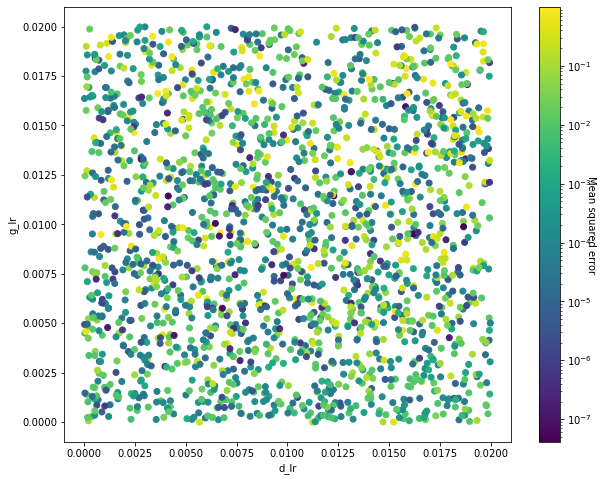

In [27]:
plot_results(bur_results, "d_lr", "g_lr")

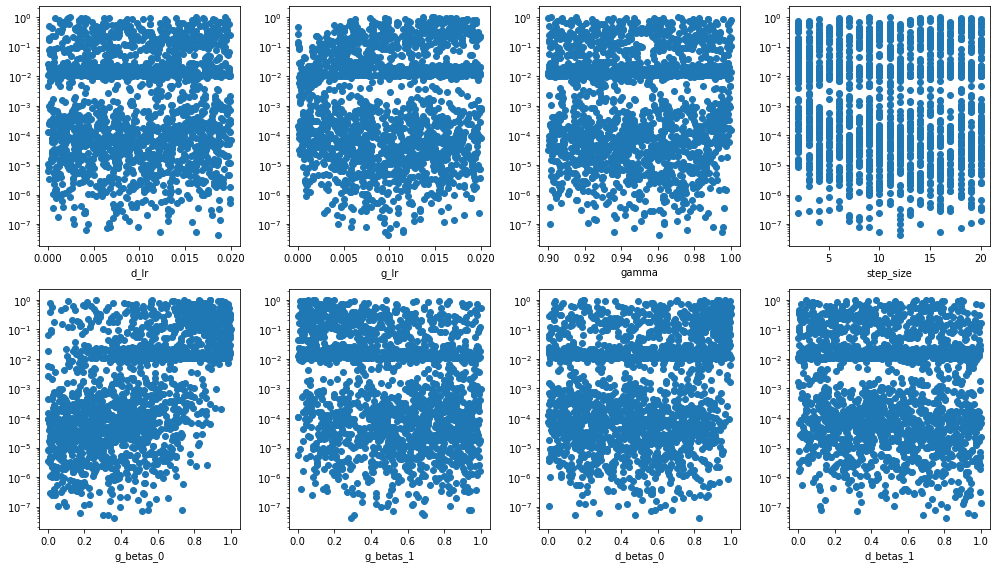

In [28]:
plot_bivariate(bur_results)

# 10. BURV

In [29]:
# Read in the BURV results
burv_results = pd.read_csv("gan_results/ray_tune_burv.csv", usecols=np.arange(1,22))
burv_results = get_expanded_df(burv_results, optim="adam")
burv_results.loc[burv_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
383,0.000003,2022-02-04_11-30-00,holy7c24304.rc.fas.harvard.edu,0,0.0054264631919862987,0.012742949817104081,0.95484413617848396,"[0.18525066902093706, 0.5941217838175823]","[0.09374523602184848, 0.18467156506542667]",20,20,50,5,3


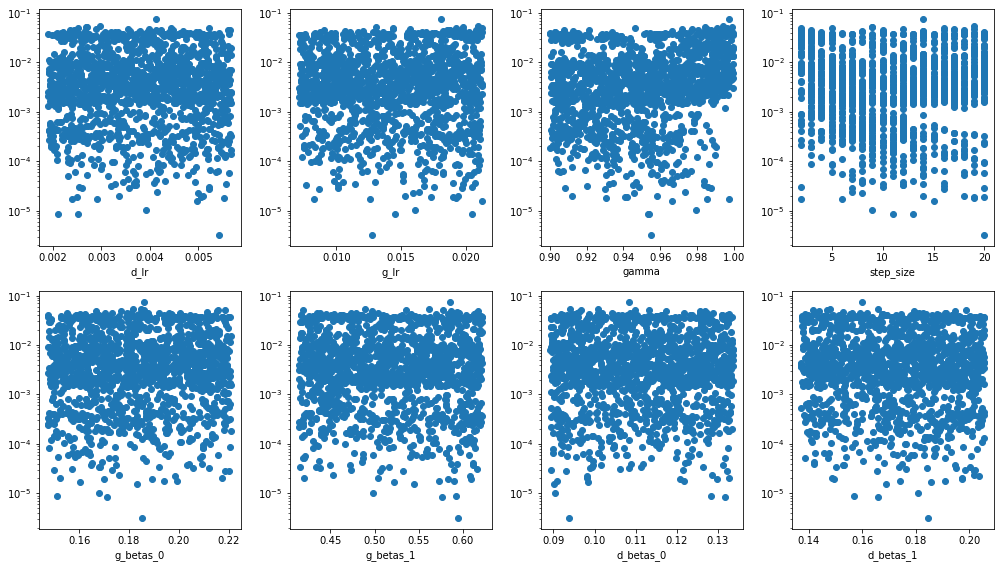

In [30]:
plot_bivariate(burv_results)

# 11. EINS

In [31]:
# Read in the EINS results
eins_results = pd.read_csv("gan_results/ray_tune_eins_scratch.csv", usecols=np.arange(1,22))
eins_results = get_expanded_df(eins_results, optim="adam")
eins_results.loc[eins_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
5,0.000397,2022-02-01_22-47-50,holy7c24402.rc.fas.harvard.edu,2,0.0066202471358984064,0.011771948721017536,0.99636960565324184,"[0.2029651593008378, 0.9750849414887578]","[0.15440781182744195, 0.7970585213385728]",17,30,40,2,4


In [32]:
# Read in the EINS results
eins_results = pd.read_csv("gan_results/ray_tune_eins_pretrained.csv", usecols=np.arange(1,22))
eins_results = get_expanded_df(eins_results, optim="adam")
eins_results.loc[eins_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
784,0.001034,2022-01-24_14-44-04,holy7c24302.rc.fas.harvard.edu,0,0.015107779247395335,0.00057890631587557094,0.9308290184288095,[0.17365245 0.87249054],[0.39862633 0.90455467],2,20,20,4,3
128,0.001471,2022-01-24_13-34-25,holy7c24302.rc.fas.harvard.edu,1,0.013314134576050986,0.00021986426542146346,0.98834254768687124,[0.73306943 0.07367639],[0.54123594 0.28155474],12,30,50,4,3
968,0.000391,2022-01-24_15-24-13,holy7c24302.rc.fas.harvard.edu,2,0.012703867271028131,0.0013109727740075996,0.97676331521658999,[0.32227323 0.56971684],[0.70425699 0.85826436],19,40,50,2,2
1646,0.001003,2022-01-24_16-09-33,holy7c24302.rc.fas.harvard.edu,3,0.0056685674690609578,0.00010193065184802586,0.97705877850797007,[0.55699743 0.99329558],[0.37813088 0.14850439],15,40,50,2,3
1924,0.000907,2022-01-24_16-55-33,holy7c24302.rc.fas.harvard.edu,4,0.0092597095833733094,0.00075800047023220798,0.99415500269268808,[0.26347908 0.53268514],[0.00301453 0.90001024],12,50,30,3,5
605,0.000680,2022-01-24_14-48-00,holy7c24302.rc.fas.harvard.edu,5,0.013024764450211243,0.0014262986604038756,0.98824631761728621,[0.07466174 0.75785678],[0.23330796 0.40102511],8,50,30,3,2
1659,0.000878,2022-01-24_16-08-53,holy7c24302.rc.fas.harvard.edu,6,0.014685345422854249,4.6327258141510397e-05,0.97983114163362739,[0.85864503 0.34655332],[0.4190425 0.39555654],10,20,20,2,2
1038,0.000362,2022-01-24_15-33-36,holy7c24302.rc.fas.harvard.edu,7,0.0013847021063578639,0.00064044052778962379,0.99735444618782132,[0.19316573 0.67359447],[0.01741737 0.8363446 ],10,40,40,5,3
1278,0.001023,2022-01-24_15-34-06,holy7c24302.rc.fas.harvard.edu,8,0.0045656504765467423,0.001678705564775629,0.93234436329365245,[0.05682322 0.44295135],[0.51425688 0.06712459],9,30,30,4,2
1248,0.000912,2022-01-24_15-30-31,holy7c24302.rc.fas.harvard.edu,9,0.010710632166063558,0.00023803798533190632,0.9375815509102553,[0.40566592 0.43134151],[0.78702494 0.95543089],17,30,40,5,2


# 12. HEA

In [33]:
# Read in the HEA results
hea_results = pd.read_csv("gan_results/ray_tune_hea.csv", usecols=np.arange(1,22))
hea_results = get_expanded_df(hea_results, optim="adam")
hea_results.loc[hea_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1772,1.182369e-09,2021-11-15_16-31-11,holy7c24203.rc.fas.harvard.edu,0,0.016818687195466909,0.019200507698070912,0.93776156313612791,[0.38808966 0.88311579],[0.39247804 0.80629506],13,20,30,2,2
1823,2.153391e-09,2021-11-15_16-33-12,holy7c24203.rc.fas.harvard.edu,1,0.010022938704308929,0.0075909402892882696,0.97595509472670938,[0.38507265 0.66592619],[0.50096283 0.00676169],5,30,50,4,3
1018,7.136220e-10,2021-11-15_16-21-04,holy7c24203.rc.fas.harvard.edu,2,0.0059949237737269212,0.0091285149424974576,0.92911300383460427,[0.05834404 0.18113021],[0.43724255 0.69589482],18,50,50,3,4
149,1.066434e-09,2021-11-15_16-06-51,holy7c24203.rc.fas.harvard.edu,3,0.002497558597753424,0.012980040198643425,0.92340604861464626,[0.39556119 0.8307752 ],[0.88406968 0.84766962],18,20,30,5,4
655,1.152584e-09,2021-11-15_16-14-14,holy7c24203.rc.fas.harvard.edu,4,0.0012245791754285772,0.018357755789163242,0.94588935609793012,[0.56166167 0.68105714],[0.8974246 0.70114744],9,30,50,3,2
181,3.174361e-10,2021-11-15_16-07-18,holy7c24203.rc.fas.harvard.edu,5,0.00195769840854613,0.010861668337087982,0.95003910549481241,[0.2306765 0.65763986],[0.12032453 0.25102168],10,30,40,2,4
462,3.587127e-10,2021-11-15_16-12-15,holy7c24203.rc.fas.harvard.edu,6,0.0035862235397147563,0.018151170406050264,0.9370156458083776,[0.31513985 0.29894257],[0.34206228 0.85235759],17,30,40,2,3
789,1.689041e-09,2021-11-15_16-17-30,holy7c24203.rc.fas.harvard.edu,7,0.016571161170983957,0.014091218993764034,0.9188625067266939,[0.16355336 0.39800136],[0.62051388 0.2966492 ],18,40,50,2,5
237,7.336395e-10,2021-11-15_16-08-52,holy7c24203.rc.fas.harvard.edu,8,0.00060098298012296837,0.01264753519670604,0.95710768263522372,[0.63085335 0.81289284],[0.56437422 0.22023844],12,30,40,2,4
559,5.483735e-10,2021-11-15_16-13-35,holy7c24203.rc.fas.harvard.edu,9,0.0021266943857337741,0.018961461880126342,0.97490912911733374,[0.31348707 0.3466119 ],[0.75397888 0.79914066],7,40,30,4,3


# 13. ACA

In [34]:
# Read in the ACA results (no lambda)
aca_results = pd.read_csv("gan_results/ray_tune_aca.csv", usecols=np.arange(1,22))
aca_results = get_expanded_df(aca_results, optim="adam")
aca_results.loc[aca_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
278,0.080638,2022-01-03_15-38-28,holy7c24304.rc.fas.harvard.edu,0,0.012461112095652054,0.0077545459351693732,0.98461295608101074,[0.54188141 0.56425945],[0.76517013 0.26138922],18,20,50,2,4
220,0.313146,2022-01-03_15-33-38,holy7c24304.rc.fas.harvard.edu,1,0.017189383558367528,0.0093636336257704681,0.99409174418527635,[0.51559746 0.45091836],[0.17195545 0.02950189],4,30,50,2,3
306,0.039628,2022-01-03_16-12-05,holy7c24304.rc.fas.harvard.edu,2,0.014612174541888658,0.011573149489920082,0.97657319879030746,[0.58364223 0.80677563],[0.83692246 0.93493793],19,30,40,3,4
941,0.062281,2022-01-03_18-02-54,holy7c24304.rc.fas.harvard.edu,3,0.0055277360977895899,0.01521432863188951,0.96786150239694979,[0.40930702 0.89227435],[0.69429452 0.35781406],12,30,40,4,4
813,0.053949,2022-01-03_17-35-10,holy7c24304.rc.fas.harvard.edu,4,0.0043422271972585061,0.0086984583166699377,0.96240575975430898,[0.41448104 0.24198105],[0.8709293 0.76397605],17,30,40,3,2
756,0.128441,2022-01-03_17-17-55,holy7c24304.rc.fas.harvard.edu,5,0.010621563803281964,0.008709619639021041,0.98528324488553765,[0.67254396 0.97717181],[0.80993622 0.20925233],5,30,40,3,2
121,0.189970,2022-01-03_14-54-29,holy7c24304.rc.fas.harvard.edu,6,0.0034101330055092546,0.0053221081120026293,0.97032203814679674,[0.18982682 0.51885082],[0.96992078 0.38779919],7,50,30,5,2
272,0.257727,2022-01-03_15-25-42,holy7c24304.rc.fas.harvard.edu,7,0.010664990603338687,0.0049805430400903083,0.98725601168269495,[0.13512713 0.59514977],[0.62722275 0.46187463],7,50,30,4,3
639,0.030924,2022-01-03_17-46-27,holy7c24304.rc.fas.harvard.edu,8,0.018659887517260301,0.013062663284027502,0.98905978163111818,[0.59484321 0.9425278 ],[0.8017268 0.37476167],13,50,40,5,3
169,0.335006,2022-01-03_15-14-47,holy7c24304.rc.fas.harvard.edu,9,0.0090617966842871725,0.019785234204572202,0.96018424291451487,[0.30096164 0.27705229],[0.4334178 0.53964633],13,40,40,3,3


In [35]:
# Read in the ACA results with lambda tuning (adding lambda to 1-e^-t reparam)
aca_results = pd.read_csv("gan_results/ray_tune_aca_lambda1.csv", usecols=np.arange(1,22))
aca_results = get_expanded_df(aca_results, optim="adam", lam=True)
aca_results.loc[aca_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers,lam
704,0.024603,2022-02-04_21-53-49,holy7c24104.rc.fas.harvard.edu,8,0.019455018087453271,0.0065697659610325313,0.99625283175608714,"[0.6763056789674198, 0.929392146714848]","[0.7912041860241598, 0.4000328924321289]",5,30,30,2,2,2.786311936631952


In [36]:
# Read in the ACA results with lambda tuning (multiplying LHS by e^-t/lam)
aca_results = pd.read_csv("gan_results/ray_tune_aca_lambda2.csv", usecols=np.arange(1,22))
aca_results = get_expanded_df(aca_results, optim="adam", lam=True)
aca_results.loc[aca_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers,lam
1030,0.00566,2022-02-06_02-19-40,holy7c24302.rc.fas.harvard.edu,8,0.01796173909426544,0.015273297142915698,0.99194776858595657,"[0.5230705335849305, 0.8481529983571873]","[0.5711086968072553, 0.3255598845890711]",10,50,40,3,5,1.026203561158755


In [37]:
# Read in the ACA results with lambda tuning with no reparameterization
aca_results = pd.read_csv("gan_results/ray_tune_aca_noreparam.csv", usecols=np.arange(1,22))
aca_results = get_expanded_df(aca_results, optim="adam", lam=True)
aca_results.loc[aca_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers,lam
117,0.026078,2022-02-15_23-17-02,holy7c24402.rc.fas.harvard.edu,8,0.00048725556891163397,0.014179305584180211,0.98658132308066182,"[0.10486488000379848, 0.8169012181734001]","[0.1931977945909574, 0.8690174037085089]",11,50,40,2,2,3.8941521770181513


# 14. RAYS

## 14.1 Regular GAN

In [38]:
# Read in the RAYS results
rays_results = pd.read_csv("gan_results/ray_tune_rays_fixed.csv", usecols=np.arange(1,22))
rays_results = get_expanded_df(rays_results, optim="adam")
rays_results.loc[rays_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
487,7.754963e-08,2022-02-15_09-12-30,holy7c24303.rc.fas.harvard.edu,2,0.0041272976272267361,0.0093581768678081979,0.97893579812771658,"[0.21932425228717567, 0.7154610394492373]","[0.15260135969704555, 0.7677411091156993]",13,20,50,2,2


## 14.2 Multi-headed GAN (`n_heads=5`)

`y0 = [0.2, 0.3, 0.4, 0.5, 0.6]`

In [39]:
# Read in the RAYS results
rays_results = pd.read_csv("gan_results/ray_tune_rays_5head.csv", usecols=np.arange(1,22))
rays_results = get_expanded_df(rays_results, optim="adam")
rays_results.loc[rays_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1530,7.494684e-09,2022-02-26_03-34-04,holy7c24301.rc.fas.harvard.edu,2,0.0048023711791343685,0.015060491594356819,0.95689343425192619,"[0.2821835930149624, 0.7315612824266313]","[0.0331345656344045, 0.9823183248176964]",18,30,40,2,5


## 14.3 Multi-headed GAN (`n_heads=10`)

`y0 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`

In [40]:
# Read in the RAYS results
rays_results = pd.read_csv("gan_results/ray_tune_rays_10head.csv", usecols=np.arange(1,22))
rays_results = get_expanded_df(rays_results, optim="adam")
rays_results.loc[rays_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
635,4.939148e-09,2022-02-26_16-31-12,holy7c24302.rc.fas.harvard.edu,2,0.014701126299350388,0.016968405344885185,0.97974529808687616,"[0.33064079721786144, 0.8436569162245784]","[0.14653098871846024, 0.9308375402663077]",15,50,40,2,3


## 14.4 Multi-headed GAN (`n_heads=11`)

`y0 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`

In [45]:
# Read in the RAYS results
rays_results = pd.read_csv("gan_results/ray_tune_rays_11head.csv", usecols=np.arange(1,22))
rays_results = get_expanded_df(rays_results, optim="adam")
rays_results.loc[rays_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1991,5.197589e-08,2022-03-02_05-24-18,holy7c24104.rc.fas.harvard.edu,2,0.0037547474147429367,0.012316433526697611,0.98944605908056127,"[0.3321397465281695, 0.7814519177699136]","[0.08849280706193198, 0.9920535299846108]",11,50,20,2,5


## 14.4 Multi-headed GAN (`n_heads=15`)

`y0 = [0., 0.07142857, 0.14285714, 0.21428571, 0.28571429, 0.35714286, 0.42857143, 0.5, 0.57142857, 0.64285714,
  0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.]`

In [44]:
# Read in the RAYS results
rays_results = pd.read_csv("gan_results/ray_tune_rays_15head.csv", usecols=np.arange(1,22))
rays_results = get_expanded_df(rays_results, optim="adam")
rays_results.loc[rays_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
648,0.000049,2022-03-01_14-20-58,holy7c24101.rc.fas.harvard.edu,2,0.015452633350580029,0.01152380515461927,0.97782604967996123,"[0.22881133152941593, 0.69984895289804]","[0.2758524687122676, 0.8291734341043192]",11,70,50,4,4


## 14.5 Multi-headed GAN (`n_heads=20`)

`y0 = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7. 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]`

In [41]:
# Read in the RAYS results
rays_results = pd.read_csv("gan_results/ray_tune_rays_20head.csv", usecols=np.arange(1,22))
rays_results = get_expanded_df(rays_results, optim="adam")
rays_results.loc[rays_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
308,0.000127,2022-02-28_01-10-46,holy7c24304.rc.fas.harvard.edu,2,0.016278435456785537,0.015028522387107234,0.97508250750164049,"[0.06283051772207576, 0.9836998378375152]","[0.21522197713939137, 0.7207512868158761]",10,50,50,4,2


# All experiments

In [42]:
def plot_experiments(df_list, names):
    fig, ax = plt.subplots(figsize=(10, 8))
    for df, name in zip(df_list, names):
        df_subset = df.sort_values("mean_squared_error")[:150]
        x_vals = [float(x_i) for x_i in df_subset["d_lr"]]
        y_vals = [float(y_i) for y_i in df_subset["g_lr"]]
        ax.scatter(x_vals, y_vals, label=name, s=500, alpha=0.25)
    ax.set_xlabel("d_lr")
    ax.set_ylabel("g_lr")
    ax.legend()
    plt.show()

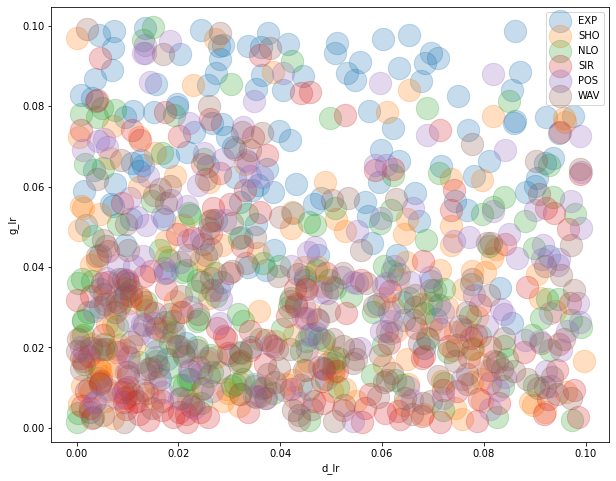

In [43]:
df_list = [exp_results, sho_results, nlo_results, sir_results, pos_results, wav_results]
names = ["EXP", "SHO", "NLO", "SIR", "POS", "WAV"]

plot_experiments(df_list, names)